# Introduction

## End-to-End Time Series Analysis & Forecasting

By Atharva Mehul Patil

This notebook demonstrates a professional end-to-end workflow for time-series forecasting, bridging the gap between scientific observation and business intelligence. By leveraging the Augmented Dickey-Fuller (ADF) test for statistical rigor and Seasonal Decomposition for structural analysis, we transition from analyzing solar cycles to building a high-precision SARIMA model for retail sales. The final architecture is refined through an AIC-driven grid search, ensuring an optimal balance between model complexity and predictive accuracy for data-driven decision-making.

## Datasets used:
Monthly Sales - https://www.kaggle.com/datasets/yohanan/monthly-sales \
Sunspots - https://www.kaggle.com/datasets/robervalt/sunspots



Importing all necessary libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import kagglehub


/Users/atharvapatil/Documents/refined notebooks for resume/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Why stationarity matters for a time series

Stationarity means the statistical properties of your data (mean, variance, and correlation) don't change over time.It is vital because most forecasting models (like ARIMA) assume that the future will look statistically similar to the past. If your data has a trend or changing volatility, those models will fail.

The Augmented Dickey-Fuller (ADF) Test is the "gold standard" for checking stationarity. It is important because you cannot always rely on your eyes to spot non-stationarity.\
    &emsp;Statistical Proof: It moves beyond "guessing" by providing a p-value. If the p-value is $< 0.05$, you can be confident the data is stationary.\
    &emsp;Identifies "Unit Roots": It specifically checks for a "unit root," a mathematical property that causes a series to drift unpredictably.\
    &emsp;Decides Your Strategy: The ADF result tells you exactly what to do next:\
        &emsp;&emsp;Pass (Stationary): Start modeling immediately.\
        &emsp;&emsp;Fail (Non-Stationary): You must apply differencing or transformations before proceeding.


# The Sunspots Case Study
## Using the Sunspot dataset for statistical rigor

Loading and preparing the sunspot data

In [4]:
sunspots_path = kagglehub.dataset_download("robervalt/sunspots")

In [5]:
print(sunspots_path + "/Sunspots.csv")
sunspot_df = pd.read_csv(sunspots_path + "/Sunspots.csv")

/Users/atharvapatil/.cache/kagglehub/datasets/robervalt/sunspots/versions/3/Sunspots.csv


In [6]:
sunspot_df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [7]:
sunspot_df = sunspot_df.drop("Unnamed: 0", axis=1)
sunspot_df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


Sunspot Visualization

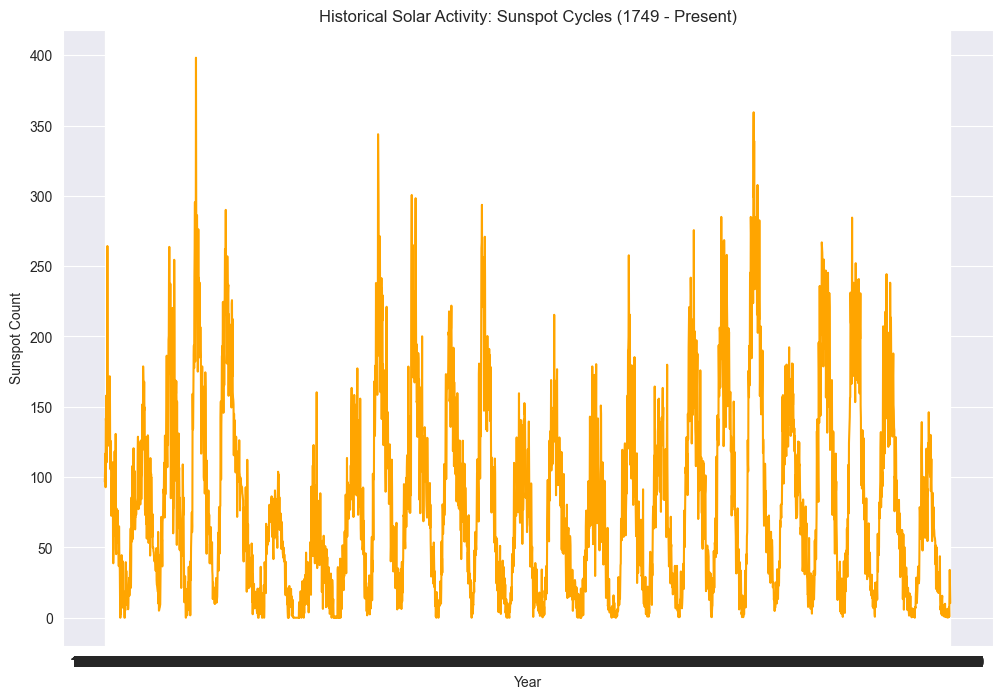

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(sunspot_df['Date'], sunspot_df['Monthly Mean Total Sunspot Number'], color='orange')
plt.title('Historical Solar Activity: Sunspot Cycles (1749 - Present)')
plt.xlabel('Year')
plt.ylabel('Sunspot Count')
plt.show()

Visualizing the 'Random Walk' vs. Predictable Cycles

To understand non-stationarity, we visualize a Random Walk. A random walk represents pure uncertainty; in contrast, our Sunspot data shows structured cycles.

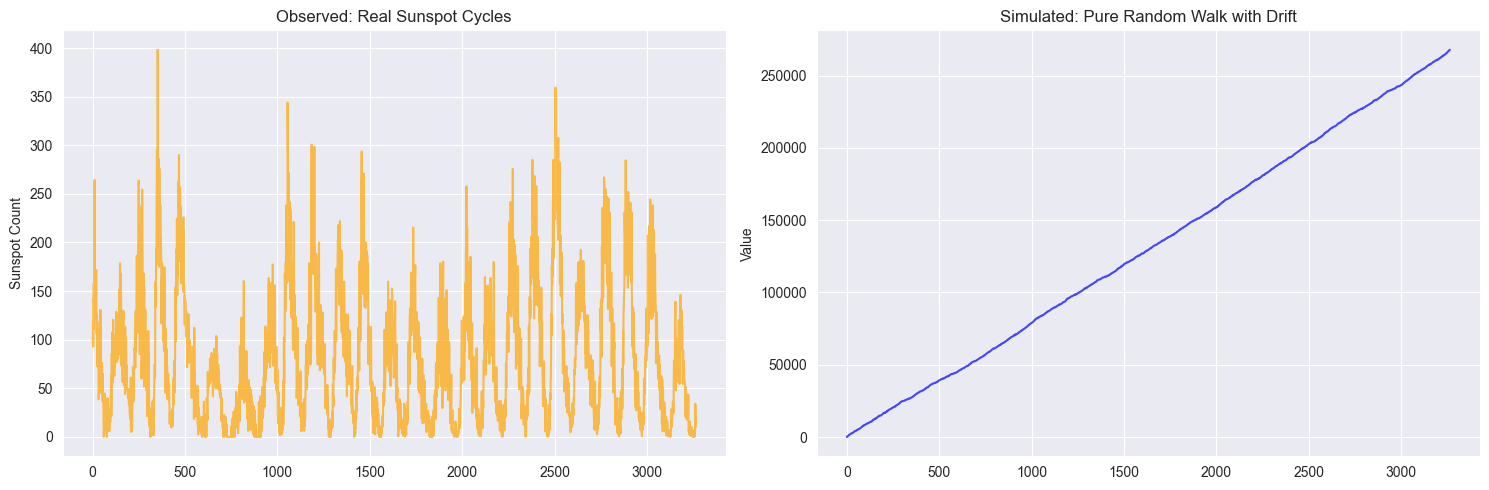

In [9]:
dt = 1
sigma = sunspot_df['Monthly Mean Total Sunspot Number'].std()
mu = sunspot_df['Monthly Mean Total Sunspot Number'].mean()
random_walk = [sunspot_df['Monthly Mean Total Sunspot Number'].iloc[0]]

for _ in range(len(sunspot_df) - 1):
    # this simulates a non-stationary series (a "Random Walk")
    next_value = random_walk[-1] + mu * dt + sigma * np.random.normal(0, np.sqrt(dt))
    random_walk.append(next_value)


plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
plt.plot(sunspot_df['Monthly Mean Total Sunspot Number'], color='orange', alpha=0.7)
plt.title('Observed: Real Sunspot Cycles')
plt.ylabel('Sunspot Count')

# simulated random walk
plt.subplot(1, 2, 2)
plt.plot(random_walk, color='blue', alpha=0.7)
plt.title('Simulated: Pure Random Walk with Drift')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

The ADF Test Function\
As seen above, the Random Walk drifts indefinitely, while the Sunspot data remains bounded. The ADF Test will mathematically confirm this difference.

In [10]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Conclusion: Stationary")
    else:
        print("Conclusion: Non-Stationary")

adf_test(sunspot_df['Monthly Mean Total Sunspot Number'])

ADF Statistic: -10.497051662546145
p-value: 1.1085524921956104e-18
Conclusion: Stationary


# The Monthly Sales Case Study - Retail Sales Forecasting
Having established our testing framework, we now apply it to a business context. Retail sales data is notoriously difficult to forecast because it contains both long-term growth and seasonal spikes.

The Objective: To build a predictive model that can handle both a long-term upward trend and significant seasonal fluctuations (e.g., holiday spikes).

The Methodology:

&emsp;Preprocessing: Aligning data to a monthly frequency.

&emsp;Decomposition: Separating the signal into Trend, Seasonality, and Residuals.

&emsp;Modeling: Implementing SARIMA (Seasonal ARIMA) to capture recurring yearly patterns.

## Loading and preparing the monthly sales data

In [11]:
monthlySales_path = kagglehub.dataset_download("yohanan/monthly-sales")
print(monthlySales_path + "/MonthlySales.csv")
sales_df = pd.read_csv(monthlySales_path+ "/MonthlySales.csv")

/Users/atharvapatil/.cache/kagglehub/datasets/yohanan/monthly-sales/versions/1/MonthlySales.csv


In [12]:
sales_df

,month,sales
0,2013-01-01,14236.90
1,2013-02-01,4519.89
2,2013-03-01,55691.01
3,2013-04-01,28295.35
4,2013-05-01,23648.29
5,2013-06-01,34595.13
6,2013-07-01,33946.39
7,2013-08-01,27909.47
8,2013-09-01,81777.35
9,2013-10-01,31453.39


In [13]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   48 non-null     object 
 1   sales   48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


Converting to Datetime Index

In [14]:
sales_df['month'] = pd.to_datetime(sales_df['month'])
sales_df.set_index('month', inplace=True)
sales_df.index.freq = 'MS'
sales_df.head()

,sales
month,
2013-01-01,14236.90
2013-02-01,4519.89
2013-03-01,55691.01
2013-04-01,28295.35
2013-05-01,23648.29


## Extracting the Signal: Time-Series Decomposition
We decompose the sales data to separate the "Trend" (overall growth) from the "Seasonality" (holiday cycles). This diagnostic step dictates our model choice.

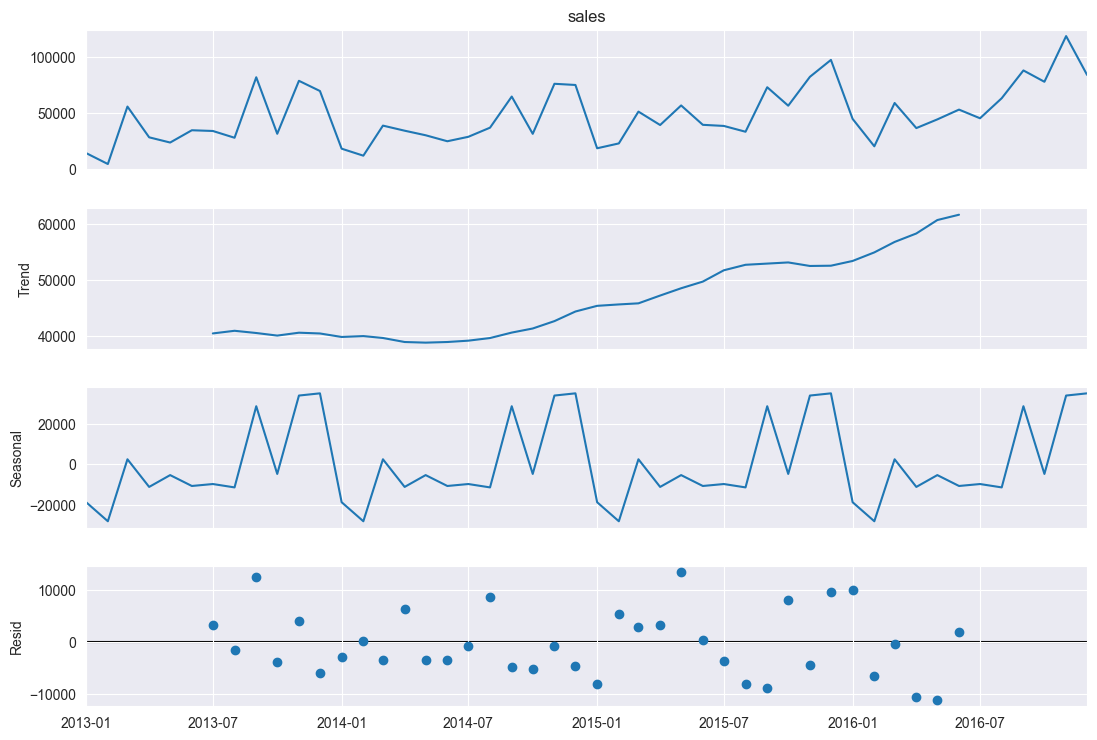

In [15]:
decomposition = seasonal_decompose(sales_df['sales'], model='additive')

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

## Statistical Validation
Applying the ADF Test to sales df

In [16]:
print("ADF test results for the monthly sales data")
adf_test(sales_df['sales'])

ADF test results for the monthly sales data
ADF Statistic: -4.481466822793171
p-value: 0.00021237148833135093
Conclusion: Stationary


### Observation

Interestingly, the ADF test returns a p-value of 0.0002123, suggesting the series is stationary. However, our visual decomposition clearly shows an upward trend.

### Next Step

Even though the test suggests stationarity, the presence of a visual trend and strong seasonality means that a standard ARMA model will likely underfit. To be conservative and ensure the model accounts for the growth seen in the decomposition, we will apply First-Order Differencing and Seasonal Differencing within our SARIMA Model.

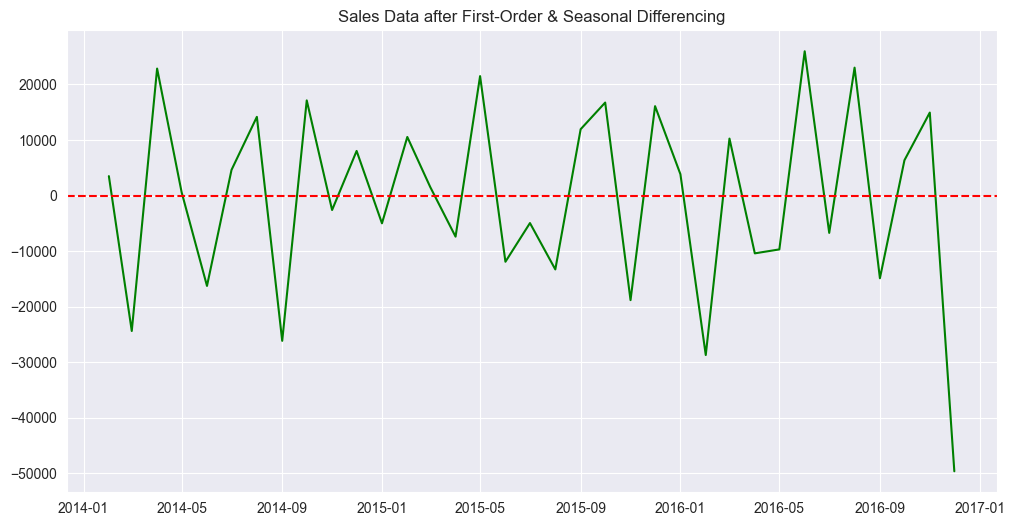

In [17]:
# applying first-order and seasonal differencing to see the impact
sales_df['diff'] = sales_df['sales'].diff().diff(12).dropna()

plt.figure(figsize=(12,6))
plt.plot(sales_df['diff'], color='green')
plt.title('Sales Data after First-Order & Seasonal Differencing')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [18]:
print("ADF Test Results after Differencing:")
adf_test(sales_df['diff'].dropna())

ADF Test Results after Differencing:
ADF Statistic: -4.80327505676121
p-value: 5.36067796467034e-05
Conclusion: Stationary


## Modelling
### Why SARIMA?
Our decomposition revealed a 12-month cycle. Standard ARIMA models cannot capture this "memory" of previous years. Therefore, we implement SARIMA, which adds seasonal parameters to the ARIMA framework. Even though the series is technically stationary, we will test both (d=0) and (d=1) in our SARIMA configuration to see which minimizes thge AIC (Akaike Information Criterion), ensuring we don't ignore the visible long-term trend.

### Visualizing Lags for Identifying Model Parameters

To determine the optimal orders for our AR (Auto-Regressive) and MA (Moving Average) components, we examine the Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots.\
&emsp;ACF: Helps identify the Moving Average ($q$) order.\
&emsp;PACF: Helps identify the Auto-Regressive ($p$) order.\
&emsp;Seasonal Lags: We look for significant spikes at lag 12, 24, etc., to justify the Seasonal ($P, D, Q$) components.


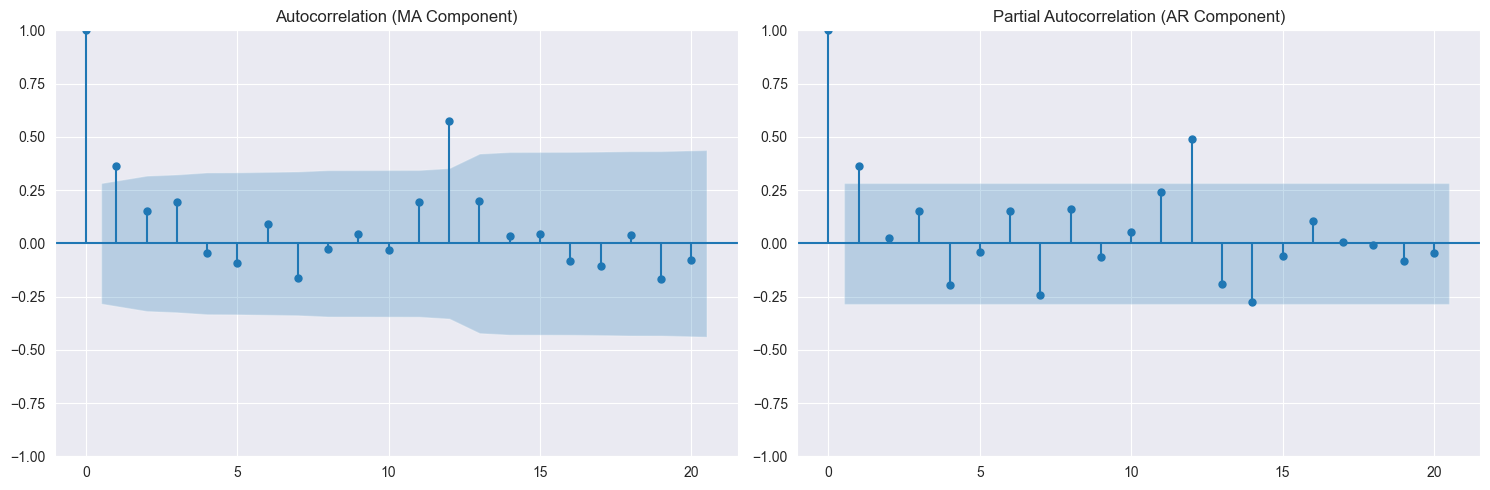

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ACF to identify 'q'
plot_acf(sales_df['sales'], lags=20, ax=ax[0])
ax[0].set_title('Autocorrelation (MA Component)')

# PACF to identify 'p'
plot_pacf(sales_df['sales'], lags=20, ax=ax[1]) # can only compute partial correlations for lags up to 50% of the sample size. So up to 24 for sample size of 48
ax[1].set_title('Partial Autocorrelation (AR Component)')

plt.tight_layout()
plt.show()

### Parameter Selection
A significant spike at Lag 12 in the ACF confirms that the current month's sales are heavily influenced by the sales of the same month last year. The PACF shows a significant spike at Lag 1 and then cuts off. This justifies a $p=1$ (Auto-Regressive) component. The ACF shows a trailing decay, suggesting a $q=1$ (Moving Average) component is appropriate to smooth out short-term shocks.\
 We will use SARIMA (1, 0, 1) x (1, 1, 1, 12). We use $D=1$ (Seasonal Differencing) specifically because of that strong Lag 12 spike.

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(sales_df['sales'],
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
# increasing maxiter and specifying the solver to resolve ConvergenceWarnings
results = model.fit(maxiter=200, method='lbfgs', disp=False)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -238.392
Date:                            Wed, 14 Jan 2026   AIC                            486.784
Time:                                    16:00:53   BIC                            492.239
Sample:                                01-01-2013   HQIC                           488.069
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9923      0.017     59.933      0.000       0.960       1.025
ma.L1         -1.0186      0.158   

/Users/atharvapatil/Documents/refined notebooks for resume/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/atharvapatil/Documents/refined notebooks for resume/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


### Optimizing SARIMA to minimise AIC

Rather than relying solely on visual interpretations of ACF/PACF plots, we conduct a grid search across various parameter combinations. We use AIC to evaluate model quality. Low AIC means better balance between goodness-of-fit and model simplicity.\

We will perform model selection via AIC grid search


In [21]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = float("inf")
best_params = None
best_seasonal_params = None


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = SARIMAX(sales_df['sales'],
                                 order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            results = temp_model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

print(f'Best SARIMA{best_params}x{best_seasonal_params} - AIC:{best_aic}')

Best SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:463.9457710620927


Our initial visual analysis of the ACF/PACF suggested an AR(1) component ($p=1$). However, the grid search identified SARIMA(0, 1, 1)x(0, 1, 1, 12) as the superior model with an AIC of 463.95. While the ACF/PACF plots gave us a starting range (e.g., $p=1, q=1$), the Grid Search allowed us to mathematically verify the most efficient architecture.

Technical Breakdown of the Winning Parameters:\
Non-Seasonal (0, 1, 1): The model preferred First-Order Differencing ($d=1$) to stabilize the trend and a Moving Average ($q=1$) term to smooth out short-term shocks, rather than an AR term.\
Seasonal (0, 1, 1, 12): The model confirmed that Seasonal Differencing ($D=1$) and a Seasonal MA term ($Q=1$) are the most efficient ways to capture the 12-month retail cycle.

This highlights the importance of AIC-based selection. Visual cues get us close, but mathematical optimization ensures the best trade-off between accuracy and complexity.

## Valdating the Winner

We now examine the Residuals of this specific model. In an ideal model, the residuals should be White Noise (randomly distributed with no patterns), indicating that the SARIMA model has extracted all possible information from the data.

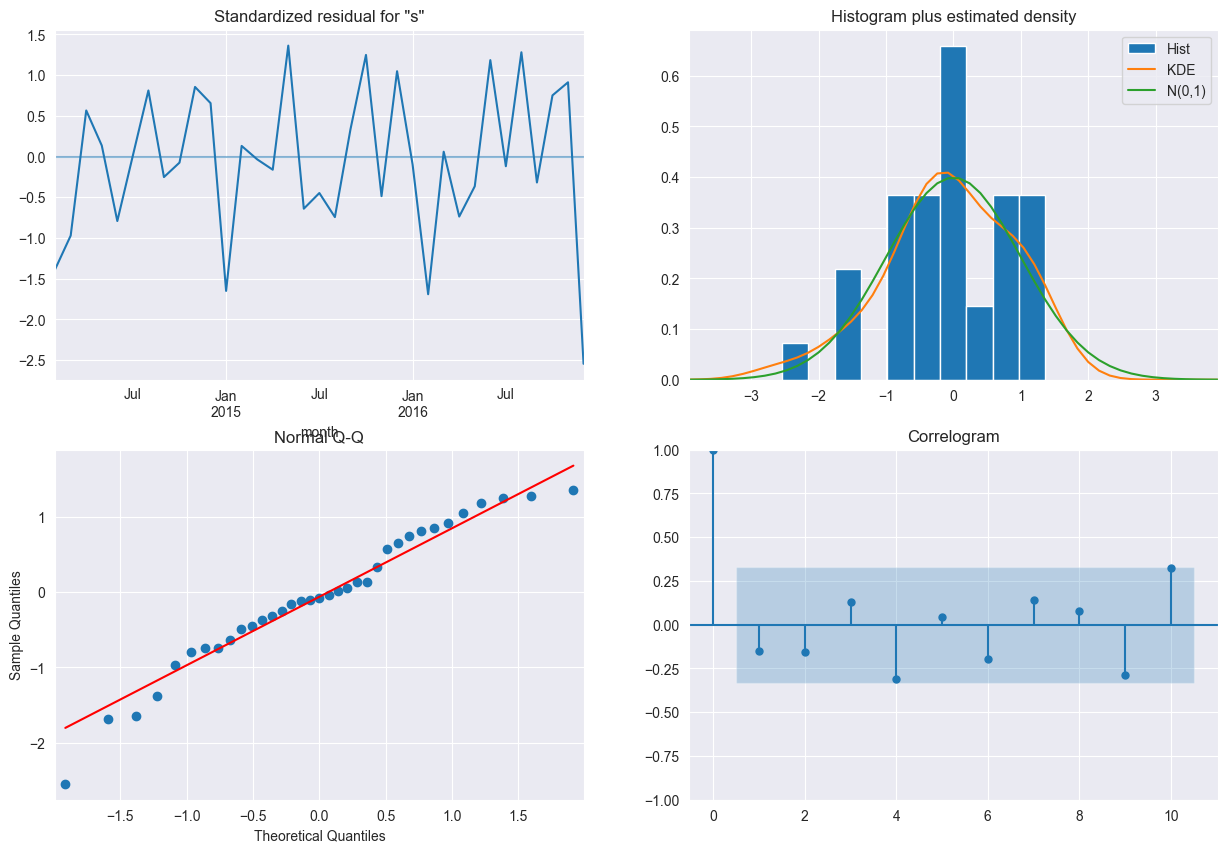

In [22]:

final_model = SARIMAX(sales_df['sales'],
                      order=best_params,
                      seasonal_order=best_seasonal_params)
results = final_model.fit()


results.plot_diagnostics(figsize=(15, 10))
plt.show()

## Final Forecast Visualization


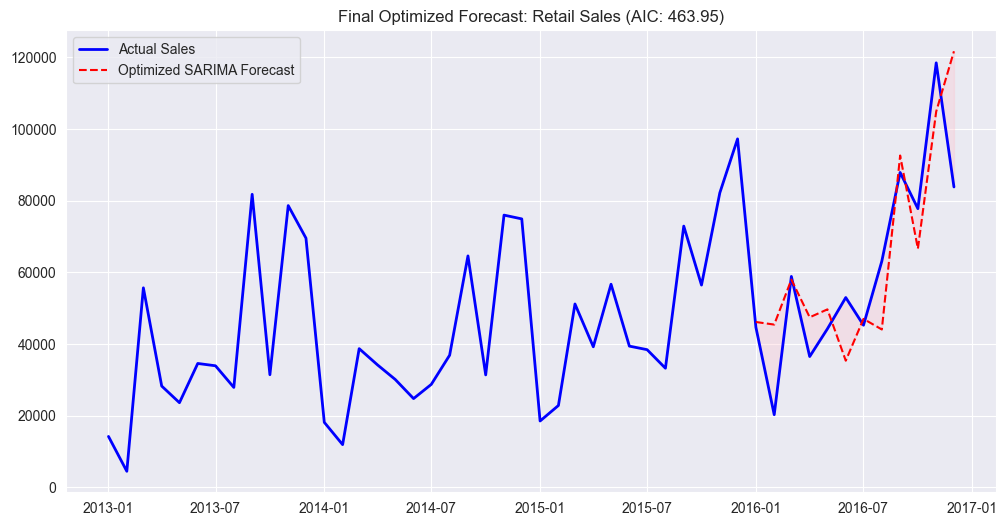

In [23]:

sales_df['forecast'] = results.predict(start=len(sales_df)-12, end=len(sales_df)+12)

plt.figure(figsize=(12, 6))
plt.plot(sales_df['sales'], label='Actual Sales', color='blue', linewidth=2)
plt.plot(sales_df['forecast'], label='Optimized SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(sales_df.index[-12:], sales_df['sales'][-12:], sales_df['forecast'][-12:], color='pink', alpha=0.3)
plt.title('Final Optimized Forecast: Retail Sales (AIC: 463.95)')
plt.legend()
plt.show()

## Conclusion and Business Impact
The model exhibits some contradictory spikes between 2016-01 and 2016-07. This indicates that the model is prioritizing 12-month seasonal memory over immediate market shifts. This divergence highlights a limitation of linear SARIMA models when facing unexpected movements that break historical retail patterns.

By using the Sunspot dataset, we validated our ability to test for stationarity and understand cyclicality. Our SARIMA model successfully captured the holiday spikes in the Monthly Sales data, even when traditional tests (ADF) provided conflicting signals regarding the trend.

This forecasting engine can be deployed for inventory optimization, ensuring that stock levels align with the 12-month seasonal demand cycles.